# Elevator Simulation

In [28]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
UP, DOWN = 1, -1

class Person: 

    def __init__(self, target_floor, spawn_timepoint) -> None:
        self.target_floor = target_floor
        self.spawn_timepoint = spawn_timepoint

class Elevator:

    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.people = []
        self.current_floor = 1
        self.current_direction = UP
    
class Building:

    def __init__(self, num_floors) -> None:
        self.num_floors = num_floors
        self.lounge = []
        for _ in range(num_floors):
            self.lounge.append([])
        self.elevator : Elevator = Elevator(5)
    
    def step(self):
        unloaded_people = [p for p in self.elevator.people if p.target_floor == self.elevator.current_floor]
        self.elevator.people = [p for p in self.elevator.people if p.target_floor != self.elevator.current_floor]
        while len(self.elevator.people)<self.elevator.capacity:
            try:
                self.elevator.people.append(self.lounge[self.elevator.current_floor-1].pop())
            except IndexError:
                break
        self.elevator.current_floor += self.elevator.current_direction
        if self.elevator.current_floor in [1, self.num_floors]:
            self.elevator.current_direction *= -1
        return unloaded_people

    def add_person(self, p :Person, floor):
        self.lounge[floor-1].append(p)

    def __str__(self) -> str:
        reprr=""
        for i, l in enumerate(self.lounge[::-1]):
            reprr+="|"+ ("<" if (self.num_floors-i)==self.elevator.current_floor else "" ) + str(self.num_floors-i) +"|\t" + "o "*len(l) + "\n"
        reprr += f"people on elevator: {len(self.elevator.people)}\n"

        return reprr


In [50]:
def simulate(_p=0.1):
    b = Building(10)
    wait_times = []
    for tstep in range(5000):
        if tstep<4000:
            p = random.random()
            if p<_p:
                cfloor = random.randint(1, 10)
                tfloor = random.randint(1,10)
                while tfloor!=cfloor:
                    tfloor = random.randint(1,10)
                b.add_person(Person(tfloor, tstep), cfloor)
        ps = b.step()
        wait_times += [tstep - p.spawn_timepoint for p in ps]
        # with open("building.txt", "w") as f:
            # f.write(str(b))
            # f.write(f"{avg_wait_time}")
        # time.sleep(0.5)
    return wait_times 

In [51]:
ps=[0.01*i for i in range(0, 100)]
ms=[]
vs=[]
for p in tqdm(ps):
    wait_times = []
    for _ in range(100):
        s = simulate(p)
        wait_times.append(np.mean(s))
    ms.append(np.mean(wait_times))
    vs.append(np.std(wait_times)/np.mean(wait_times))

  0%|          | 0/100 [00:00<?, ?it/s]

/home/bashir/.python-venv/scipy/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bashir/.python-venv/scipy/lib64/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


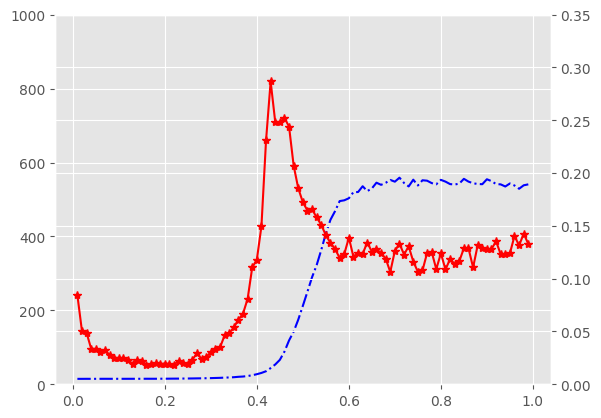

In [52]:
with plt.style.context('ggplot'):
    plt.plot(ps, ms, "b-.")
    plt.ylim(0, 1000)
    plt.twinx()
    plt.plot(ps, vs, "r-*")
    plt.ylim(0, 0.35)

is this a phase transition???